In [18]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import json
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# Expected file structure
"""
├── airport
│   ├── airport_CapeTown_aerial.png
│   ├── airport_CapeTown.png
│   ├── airport_short.mp4
│   ├── airport_short.txt
│   ├── cams_info.mat
│   ├── images
│   │   ├── img_0001.jpg
            ...
│   │   └── img_0359.jpg
│   ├── kp_gmaps.mat
│   └── yolo
│       ├── yolo_0001.mat
            ...
│       └── yolo_0359.mat
├── airport.ipynb
"""

'\n├── airport\n│\xa0\xa0 ├── airport_CapeTown_aerial.png\n│\xa0\xa0 ├── airport_CapeTown.png\n│\xa0\xa0 ├── airport_short.mp4\n│\xa0\xa0 ├── airport_short.txt\n│\xa0\xa0 ├── cams_info.mat\n│\xa0\xa0 ├── images\n│\xa0\xa0 │\xa0\xa0 ├── img_0001.jpg\n            ...\n│\xa0\xa0 │\xa0\xa0 └── img_0359.jpg\n│\xa0\xa0 ├── kp_gmaps.mat\n│\xa0\xa0 └── yolo\n│\xa0\xa0     ├── yolo_0001.mat\n            ...\n│\xa0\xa0     └── yolo_0359.mat\n├── airport.ipynb\n'

In [20]:

data_path = Path(os.getcwd()) / 'airport'

aerial_fpath = (data_path / './airport_CapeTown_aerial.png')
first_frame_fpath = (data_path / './airport_CapeTown.png')

yolo_fpaths = sorted((data_path / 'yolo').glob('*.mat'),
                     key=lambda x: int(x.stem.split('_')[1])
                    )

img_fpaths = sorted((data_path / 'images').glob('*.jpg'),
                     key=lambda x: int(x.stem.split('_')[1])
                    )

with open('yolo_classes.json', 'r') as file:
    yolo_classes = json.load(file)['class']


In [21]:
# Assert same number of images and yolo files
assert len(img_fpaths) == len(yolo_fpaths)

# Assert ordered images and yolo files
for i in range(len(img_fpaths)):
    assert img_fpaths[i].stem.split('_')[1] == yolo_fpaths[i].stem.split('_')[1]

# 1. Visualizing available data

In [22]:
file_path = Path('kp_gmaps.mat')
matches = sp.io.loadmat(data_path/file_path)['kp_gmaps']
match_video = matches[:,:2]
match_maps = matches[:,2:]

print("Shape of match_video:", match_video.shape)
print("Shape of match_maps:", match_maps.shape)

Shape of match_video: (8, 2)
Shape of match_maps: (8, 2)


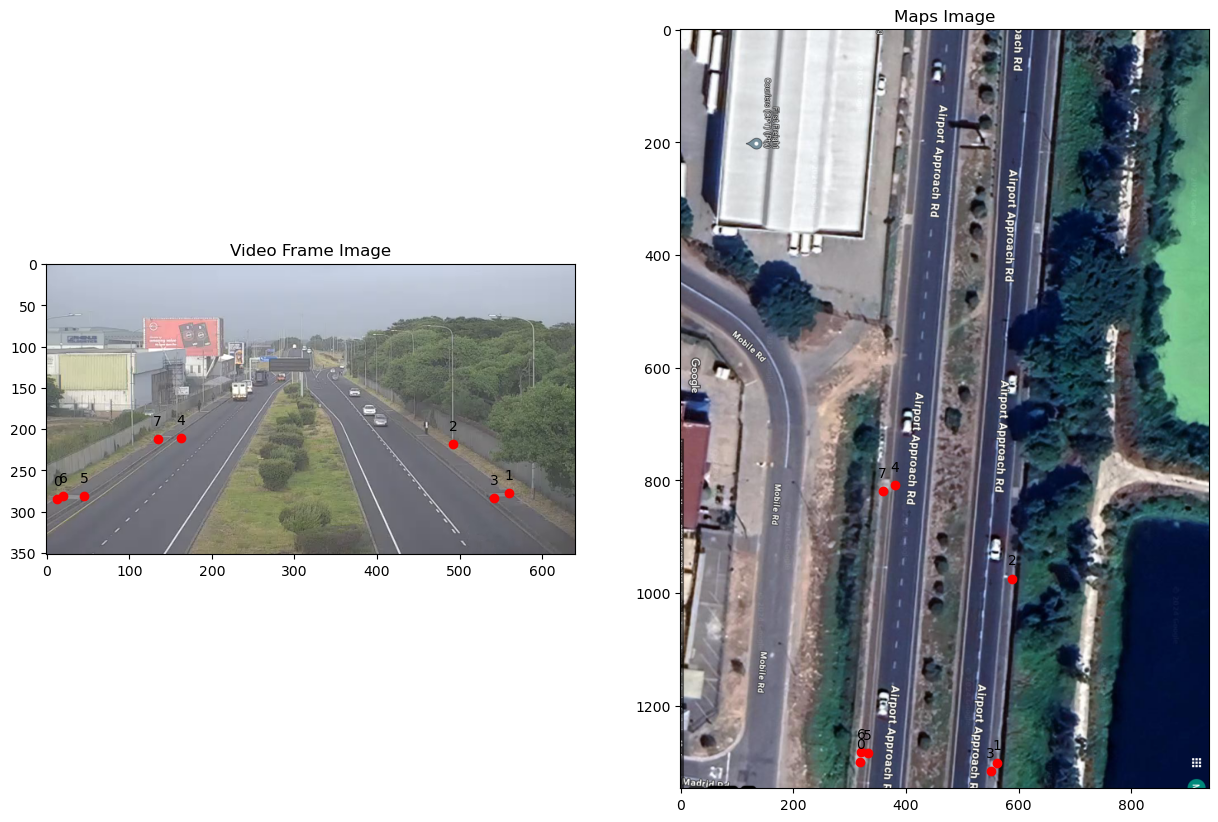

In [23]:
from utils import plot_image_with_points

aerial_img = Image.open(aerial_fpath)
first_frame_img = Image.open(first_frame_fpath)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

plot_image_with_points(axes[0], np.array(first_frame_img), match_video, 'Video Frame Image')    
plot_image_with_points(axes[1], np.array(aerial_img), match_maps, 'Maps Image')
plt.show()

In [24]:
yolo_data = sp.io.loadmat(yolo_fpaths[0])
frame_0001_img = Image.open(img_fpaths[0])

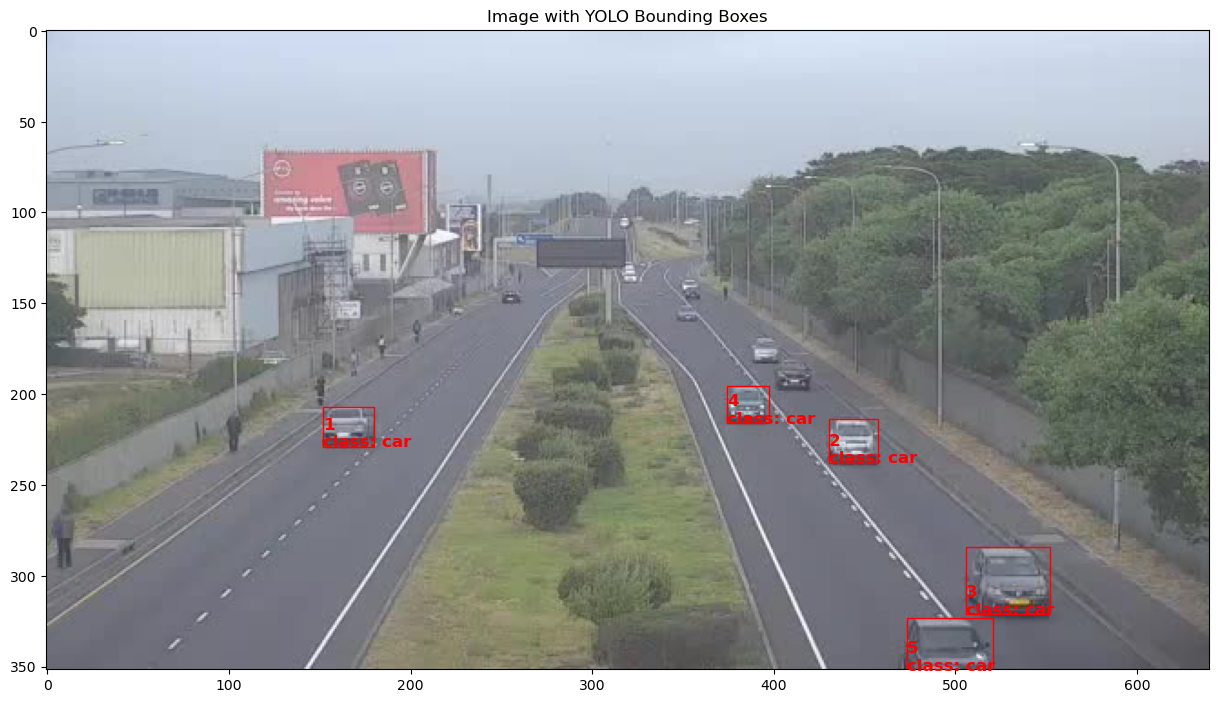

In [25]:
from utils import plot_img_with_yolo

fig, ax = plt.subplots(figsize=(15, 10))
plot_img_with_yolo(ax, np.array(frame_0001_img), yolo_data, yolo_classes)
plt.show()

# 2. Compute homography

In [26]:
A = []
def compute_segment_A(x1, y1, x2, y2):
    return [
        [x1, y1, 1, 0, 0, 0, -x1*x2, -y1*x2, -x2],
        [0, 0, 0, x1, y1, 1, -x1*y2, -y1*y2, -y2]
    ]

for x_vid, y_vid, x_map, y_map in matches:
    A.extend(compute_segment_A(x_vid, y_vid, x_map, y_map))

A = np.array(A)

In [27]:
U, S, Vt = np.linalg.svd(A)
# h is the last column of V
H = Vt.T[:, -1].reshape(3, 3)

In [28]:
# Visualizing the homography for the matches

def apply_homography_to_point(H, x, y):
    p = np.array([x, y, 1])
    p_prime = H @ p
    p_prime /= p_prime[2]
    return p_prime[:2]

for x_vid, y_vid, x_map, y_map in matches:
    x_map_prime, y_map_prime = apply_homography_to_point(H, x_vid, y_vid)
    print(f"Transformed: ({round(x_map_prime, 2)}, {round(y_map_prime, 2)}) | Target: ({round(x_map, 2)}, {round(y_map, 2)})")

Transformed: (317.87, 1297.86) | Target: (318.38, 1300.12)
Transformed: (561.17, 1298.3) | Target: (561.62, 1301.12)
Transformed: (589.46, 974.36) | Target: (588.63, 974.12)
Transformed: (550.14, 1319.21) | Target: (550.12, 1316.62)
Transformed: (379.76, 809.93) | Target: (380.38, 808.37)
Transformed: (333.09, 1284.74) | Target: (331.62, 1283.12)
Transformed: (319.85, 1283.14) | Target: (320.38, 1282.38)
Transformed: (358.3, 816.92) | Target: (358.62, 818.62)


# 3. Applying homography for an image

In [29]:
image_coords = np.meshgrid(range(np.array(first_frame_img).shape[0]), range(np.array(first_frame_img).shape[1]))

In [58]:
image_coords

[array([[  0,   1,   2, ..., 349, 350, 351],
        [  0,   1,   2, ..., 349, 350, 351],
        [  0,   1,   2, ..., 349, 350, 351],
        ...,
        [  0,   1,   2, ..., 349, 350, 351],
        [  0,   1,   2, ..., 349, 350, 351],
        [  0,   1,   2, ..., 349, 350, 351]]),
 array([[  0,   0,   0, ...,   0,   0,   0],
        [  1,   1,   1, ...,   1,   1,   1],
        [  2,   2,   2, ...,   2,   2,   2],
        ...,
        [637, 637, 637, ..., 637, 637, 637],
        [638, 638, 638, ..., 638, 638, 638],
        [639, 639, 639, ..., 639, 639, 639]])]

In [68]:
height, width = np.array(first_frame_img).shape[:2]

In [69]:
x = image_coords[0].flatten()
y = image_coords[1].flatten()
points_stacked = np.array([x,y, np.ones_like(x)])

In [72]:
transformed_points = H @ points_stacked
mapped_coords  = transformed_points / transformed_points[2]
mapped_coords = mapped_coords[:2]